# DATA COMPRESSION & INCREMENTAL ANALYSIS OF PRINCIPAL COMPONENTS

_**Consider an appropriate dataset to experiment with data compression and incremental analysis of principal components using Principal Component Analysis (PCA).**_

In [2]:
# Import required packages

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt

## Retrieval & Preparation of Data

In [4]:
# Downloads MNIST dataset

# NOTE: Downloading this data for the first time will several minutes to complete
mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
# Checks the shape of the dataset
print(mnist.data.shape)

(70000, 784)


In [6]:
# Splits dataset into train and test set containing 60000 and 10000 instances, respectively.

X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42, stratify=mnist.target)

## Data Compression using PCA

_**Finds the compression ratio after dimensionality reduction and then performs decompression of the compressed data to its original dimensions to do visual comparision between the original and compressed data.**_

In [8]:
# PCA is initialized with the minimum requirement of explained variance
pca = PCA(n_components=0.95)

In [9]:
# Extracts prinipal components of the input data
pca.fit(X_train)

PCA(n_components=0.95)

In [10]:
# Applies the dimensionality reduction on the input data by projecting it on the
# principal components and returns the reduced data
X_train_reduced = pca.transform(X_train)

In [11]:
# Prints the number of principal components
print("Number of principal components: ", pca.n_components_)

Number of principal components:  154


**Calculates the compression**

In [13]:
# Calculates required space
# It is defined as ratio between the number of principal components that describes 
# the given variance and number of dimentions of the original dataset

required_space = pca.n_components_ / mnist.data.shape[1] * 100
print("Required space: {0:.2f}%".format(required_space))

Required space: 19.64%


In [14]:
# Calculates compression

print("Compression: {0:.2f}%".format(100 - required_space))

Compression: 80.36%


**Visual Comparision between the Original and Compressed Data**

In [16]:
# Decompress the reduced dataset back to its original dimensions i.e. 784
# by applying the inverse transformation of the PCA projection.

X_train_recovered = pca.inverse_transform(X_train_reduced)

In [17]:
# Checks the shape of the recovered dataset
print(X_train_recovered.shape)

(60000, 784)


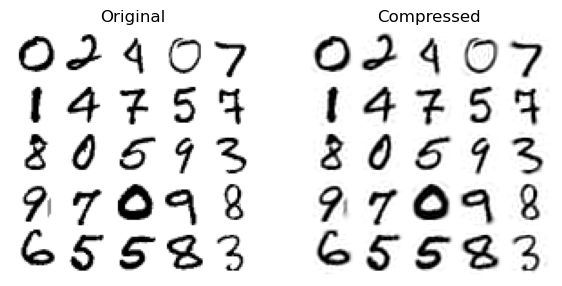

In [18]:
# Plots few digits from the original training set on the left, and
# the corresponding digits after compression and decompression

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train, X_train_recovered)):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(
                X[row * 5 + col].reshape(28, 28), 
                cmap="binary",       # colormap to refer to map input data 
                vmin=0, vmax=255,    # data range the colormap covers [to be used when input data is not normalized]
                extent=(row, row + 1, col, col + 1), # bounding box the image is stretched to fill in
            ) 
            plt.axis([0, 5, 0, 5])   # axis limits as [x_min, x_max, y_min, y_max]
            plt.axis("off")          # hides all axis decorations including labels

## Incremental Analysis of Principal Components using PCA

_**Splits data into mini-batches and feeds them into incremental PCA algorithm to apply PCA online.**_

As incremental PCA will be useful in scenario especially when training set is large and cann't be fit into memory, the following experiment simulate the same scenario considering training set being stored into a file and the task being to apply PCA incrementally in batches.

In [21]:
# First, create a training set file. Successful execution of these statements 
# would save MNIST training set into a file of size around 190 MB on disk.

train_set_memmap_filename = "./my_mnist.mmap"    # it could be any apppropriate name for the training set file

# Creates a memory-map to an array to be stored in file on disk.
X_train_memmap = np.memmap(train_set_memmap_filename, dtype="float32", mode="write", shape=X_train.shape)

# Loads the data into the memory map
X_train_memmap[:] = X_train

# Saves the data into the file on disk
X_train_memmap.flush()

Now, considering this file is large enough to load into memory, let's load the data in small batches and feed each of the batches incremental PCA algorithm.

In [23]:
# Defines number of batches
n_batches = 100

In [25]:
# Loads the memory-mapped file
X_train_memmap = np.memmap(train_set_memmap_filename, dtype="float32", mode="readonly", shape=X_train.shape)

In [26]:
# Defines size (number of instances) in each batch
n_batch_size = X_train_memmap.shape[0] // n_batches

In [27]:
# Instantiate incremental PCA algorithm

incremental_pca = IncrementalPCA(
    n_components=pca.n_components_,    # pca.n_components_ returns 154 as these number of 
                                       # components explains the given variance
    batch_size=n_batch_size)

In [28]:
# Extracts the principal components incrementally by fetching batches over 
# the memory mapped to data file on disk 

incremental_pca.fit(X_train_memmap)  # NOTE: This step may take several seconds to complete

IncrementalPCA(batch_size=600, n_components=154)

In [29]:
# Sums up variance explained by each of the 154 principal components to ensure that it is 
# equal to 95% which is the expected explained variance from the reduced data

print("Explained variance ratio by train set made of principal components: {0: .2f}%".format(
    np.sum(incremental_pca.explained_variance_ratio_)))

Explained variance ratio by train set made of principal components:  0.95%


**Observations:**

1. Visual comparision between the original and compressed data, it was noticed that there is a slight loss in image quality due to that the PCA projection lost a bit of information for the given 5% variance reduction, but the digits are still mostly intact.
2. Increamental PCA algorithm successfully extracted principal components by incrementally processing data over mini batches loaded through memory mapped data file stored on disk and it demonstrated that if the data file is large enough to be loading in memory at once, incremental PCA can be an effective way to extract principal components.